In [ ]:
#!pip install seaborn==0.11.2 tqdm matplotlib==3.7.0 statannot

In [ ]:
# run this script undere domino standard > 5.7 
!pip install statannot openpyxl nibabel seaborn boto3==1.35.20 fsspec s3fs==2024.9.0
!{'sudo apt-get install -y sshpass awscli'}

In [21]:
import numpy as np
import pandas as pd
import shutil, itertools , glob , os ,csv, re, itertools
from scipy.stats import pearsonr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nb
from statannot import add_stat_annotation

### Data Path

In [5]:
path_data = '/domino/edv/nfs-pvc/taupet/'
study_name = 'ADNIpet'
output_proc = 'Proc.domino.v1'
file_to_read = '/best/1Dstats/aparc.a2009s+aseg_rank.al.mid.PET.SUV.T807.BL.al.mid.Cerebellum.cortex.suvr.avg.stats.1D'

In [5]:
os.chdir('/domino/edv/nfs-pvc/taupet/ADNIpet')
print (os.listdir('.'))

['VROI.log', 'adni_tau.05022025.cmp_NScerebellar_gray.Xc0.10sub.1atl.690883c573cbc6de2d455f09ecc71385.rres-01.rds', 'Proc.test', '.Rhistory', 'Proc.p', 'ADNIpet_local_abalysis_SUVRs.csv', 'NIFTI', '.ipynb_checkpoints', 'adni_tau.05022025.cmp_NScerebellar_gray.Xc0.10sub.1atl.690883c573cbc6de2d455f09ecc71385.rres.rds', 'README', 'adni_tau.05022025.cmp_NScerebellar_gray.Xc0aa396d675474673c6f41fe4c7934f153.rres-01.rds', 'tmp', 'ADNI.normative.subjectIDs.07122022.csv', 'normative_subjects.txt', 'synthseg_QC.xlsx', 'Proc.domino.v1', 'adni_tau.05022025.cmp_NScerebellar_gray.Xc0aa396d675474673c6f41fe4c7934f153.rres.rds', 'ADNI-Diag.xlsx', 'subject_list', 'report_adni_aws.csv']


### Reading the Diagnosis and SUVR values

In [6]:
os.chdir(os.path.join(path_data, study_name))

#reading the diagnosis file
diag_file_tmp = pd.read_excel('ADNI-Diag.xlsx') # ---> 'ADNI-Diag_TW.xlsx' ?
diag_file_tmp = diag_file_tmp.loc[diag_file_tmp['TAUPET_avisit']=='BL',:]
diag_file = diag_file_tmp.rename(columns={'sub':'sid','BL.nsb.diag':'diag'})\
                [['sid','diag', 'TAUPET_avisit' , 'BL.AmyloidStatus','BL.nsb.age']]\
                .drop_duplicates('sid')\
                .reset_index(drop=True)

# filter subjects with amyloid positive or negative
diag_file = diag_file[diag_file['BL.AmyloidStatus'].isin(['pos','neg'])]
# change the dignosis 
dict_pos_neg={'pos':'+', 'neg':'-'}
diag_file['BL.AmyloidStatus_new']=diag_file['BL.AmyloidStatus'].map(dict_pos_neg)
diag_file['diag_status'] = diag_file['diag'] + diag_file['BL.AmyloidStatus_new']

# drop AD negative because of statistical power
diag_file_noADneg = diag_file[~(diag_file['diag_status']=='AD-')]

#diag_file = diag_file.drop(columns=['diag', 'TAUPET_avisit','BL.AmyloidStatus','BL.AmyloidStatus_new'])
#diag_file.rename(columns={'diag_status':'diag'}, inplace=True)

# find all subject ids
subjects_list = diag_file_noADneg['sid'].tolist()
# number of avialble subjects
len(subjects_list)

701

### Demographic of Subjects

In [7]:
diag_file.groupby('diag').count()

,sid,TAUPET_avisit,BL.AmyloidStatus,BL.nsb.age,BL.AmyloidStatus_new,diag_status
diag,,,,,,
AD,29,29,29,29,29,29
CN,416,416,416,416,416,416
MCI,261,261,261,261,261,261


In [8]:
diag_file[['sid','diag','BL.AmyloidStatus']].groupby(['diag','BL.AmyloidStatus']).count()

sid
diag BL.AmyloidStatus     
AD   neg                 5
     pos                24
CN   neg               283
     pos               133
MCI  neg               145
     pos               116

In [9]:
diag_file[['diag','BL.nsb.age']].groupby('diag').mean().round()

,BL.nsb.age
diag,
AD,75.0
CN,72.0
MCI,73.0


In [10]:
diag_file[['diag','BL.nsb.age']].groupby('diag').std().round()

,BL.nsb.age
diag,
AD,8.0
CN,7.0
MCI,8.0


### Convert SUVR_1D file to Braak

In [11]:
 def read_suvr_1d(proc_path, sid, file_to_read):

    # proc_path = '/domino/datasets/local/Tau_PET_spread_endpoint/ADNIpet.Proc.domino.v1/'
    # file_to_read = '/best/1Dstats/aparc+aseg_rank.al.mid.PET.SUV.T807.BL.al.mid.Cerebellum.cortex.suvr.avg.stats.1D'
    # sid = '002_S_0413'
    suvr_data_nzmean = []
    suvr_data =[]
    # creating the proc path
    if 's3' in proc_path:
        s3_list = !{'aws s3 ls ' + proc_path +sid +'/pet/'}
        s3_list = pd.Series(s3_list)
        s3_list = s3_list[s3_list.str.find('PRE compute_suvr')>0].tolist()
        if len(s3_list)>0:
            dir_name = str(s3_list[0])[str(s3_list).find('compute')-2:]
            suvr_1d_file = proc_path +sid +'/pet/' +dir_name  + suvr_1d
            suvr_data = pd.read_csv(suvr_1d_file, delimiter='\t')
    else:
        suvr_1d_file = proc_path + '/' + sid + '/' + file_to_read
        if os.path.exists(suvr_1d_file):
            suvr_data = pd.read_csv(suvr_1d_file, delimiter='\t')

    
    if len(suvr_data)>0:
        # selecting the mean value for each regions    
        suvr_data_nzmean = suvr_data[suvr_data.columns[suvr_data.columns.str.contains('NZMean')]]

        # remove NZmean from column name
        suvr_data_nzmean.columns = suvr_data_nzmean.columns.str[7:]
        suvr_data_nzmean = suvr_data_nzmean.astype(float)

    else:
        print('%s the 1D file does not exist'%(sid))  
        
    return suvr_data_nzmean   

### Data from TauQuant Analysis

In [12]:
path_data = '/domino/edv/nfs-pvc/taupet/'
study_name = 'ADNIpet'
output_proc = 'Proc.domino.v1'

tmp =[]
proc_path = path_data + study_name + '/' + output_proc + '/'
suvr_1d = '/best/1Dstats/aparc.a2009s+aseg_rank.al.mid.PET.SUV.T807.BL.al.mid.Cerebellum.cortex.suvr.avg.stats.1D'
for sid in tqdm(subjects_list):
    # reading individual braak data
    subj_data= read_suvr_1d(proc_path = proc_path,
                            sid = sid ,
                            file_to_read = suvr_1d)
    subj_data['sid']=sid
    # add to temporal list
    if len(subj_data.columns)>1:
        tmp.append(subj_data)

# merge all data
group_roi_suvr_tauquant = pd.concat(tmp).reset_index(drop=True)

100%|██████████| 701/701 [00:21<00:00, 32.36it/s]


In [13]:
group_roi_suvr = group_roi_suvr_tauquant

In [14]:
group_roi_suvr

,Left-Cerebral-White-Matter,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,ctx_rh_S_suborbital,ctx_rh_S_subparietal,ctx_rh_S_temporal_inf,ctx_rh_S_temporal_sup,ctx_rh_S_temporal_transverse,sid,non-WM-hypointensities,5th-Ventricle,Left-undetermined,ctx_lh_Medial_wall
0,1.004818,0.517422,0.966796,0.981918,0.987929,0.945981,0.844639,1.188889,1.283345,0.675815,...,0.971653,1.002227,1.123090,1.074514,1.029032,002_S_4213,NaN,NaN,NaN,NaN
1,1.051213,0.379567,0.950679,0.948105,1.004544,0.979211,0.626017,1.144640,1.148873,0.701045,...,1.072762,1.136674,1.183027,1.174129,0.980691,002_S_4229,NaN,NaN,NaN,NaN
2,1.306962,0.380818,1.150418,1.062590,1.005176,1.071660,1.207635,1.643172,1.543184,0.672954,...,2.158347,2.064047,3.057554,2.208057,1.553620,002_S_4262,NaN,NaN,NaN,NaN
3,1.300752,0.633061,1.498902,1.137481,0.982523,1.301898,1.117159,1.587625,1.595229,0.857015,...,1.397615,1.283741,1.604657,1.366492,1.222419,002_S_4654,NaN,NaN,NaN,NaN
4,1.269072,0.546059,1.264699,1.168496,1.005381,1.249459,1.231428,1.638009,1.550302,0.821323,...,1.238453,1.276641,1.380975,1.338330,1.171655,002_S_4799,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,1.069377,0.461595,0.992193,1.110714,1.062423,1.028969,0.900949,1.250485,1.414225,0.647630,...,1.061480,1.080491,1.138600,1.066491,1.153530,941_S_6575,NaN,NaN,NaN,NaN
697,1.117724,0.404668,1.142190,1.034758,0.995130,1.180339,0.910552,1.474161,1.448198,0.581176,...,1.155398,1.186951,1.354341,1.192188,1.167583,941_S_6580,NaN,NaN,NaN,NaN
698,1.111573,0.511044,1.330363,1.056963,1.004199,1.154437,1.094695,1.462739,1.637590,0.823237,...,1.154176,1.072089,1.211880,1.138976,1.048814,941_S_6581,NaN,NaN,NaN,NaN
699,1.630339,0.548779,1.050462,0.982143,1.007995,1.036496,1.040007,1.663108,1.629529,0.751396,...,1.362290,2.511245,2.722994,2.963620,1.750706,941_S_6803,NaN,NaN,NaN,NaN


### Plotting

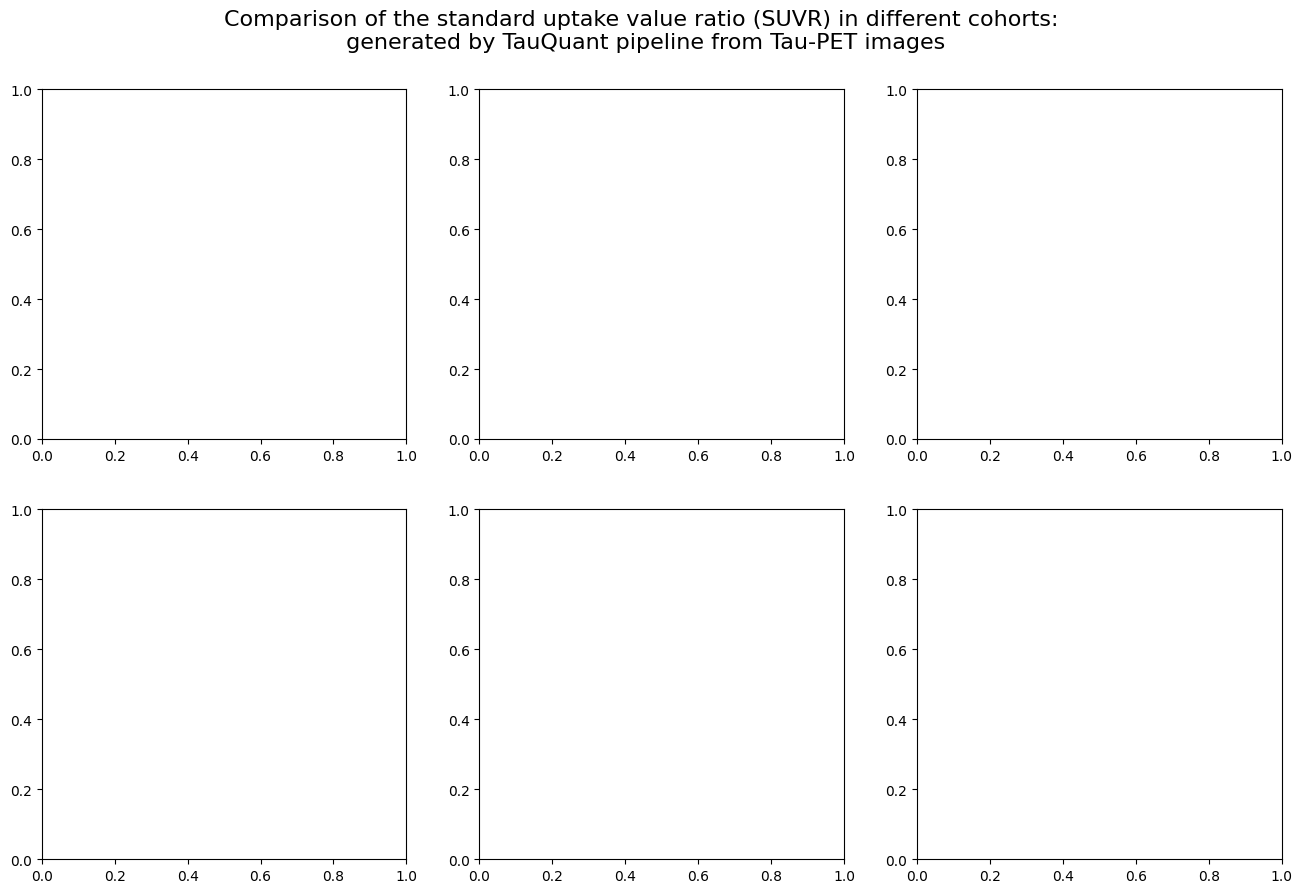

       #N  BL.AmyloidStatus
diag                       
AD     24                24
CN    416               416
MCI   261               261


In [22]:
Braak_regions = group_roi_suvr.columns[group_roi_suvr.columns.str.contains('Braak')]


# generating pairwise for t-test
pairwiseMatrix = [(("CN", "pos"), ("CN", "neg")), 
                  (("MCI", "pos"), ("MCI", "neg")),
                  (("MCI", "pos"), ("CN", "pos")),
                  (("AD", "pos"), ("CN", "pos")),
                  (("AD", "pos"), ("MCI", "pos"))] #list(itertools.combinations(diag_file['diag'].unique().tolist(), 2))

fig, axs = plt.subplots(figsize=(16, 10), nrows=2, ncols=3)
n1axs = 0
n2axs = 0
# Plot region plots for each region containing the specified substrings
for roi_name in Braak_regions:

        # Remove 'NZ_Mean_' from region_column
        plot_title = str(roi_name).replace('wmean', '').replace('_', ' ROI ', 1).replace('_', '',1)
        
        # extract the SUVR
        roi_suvr = group_roi_suvr[['sid',roi_name]]
        
        # adding the best cost and diagnosis
        roi_suvr = pd.merge(roi_suvr,diag_file, on='sid')
        
        # Cohorts SUVR
        renamed_roi_suvr = roi_suvr[[roi_name,'diag','BL.AmyloidStatus']]\
                                    .set_index('diag')\
                                    .reset_index()\
                                    .rename(columns={roi_name:'SUVR'})
        # change SUVR to float
        renamed_roi_suvr['SUVR'] = renamed_roi_suvr['SUVR'].astype(float)
        
        # Add in points to show each observation
        sns.stripplot(data= renamed_roi_suvr, 
                      x='diag',
                      y='SUVR', 
                      dodge=True,
                      zorder=0,
                      hue='BL.AmyloidStatus',
                      palette=custom_palette3,
                      marker="o", linewidth=1, alpha=.3,
                      ax=axs[n1axs,n2axs])
        
        # Plot the orbital period with horizontal boxes
        sns.boxplot(
            data= renamed_roi_suvr, 
            x='diag', 
            y='SUVR', 
            hue='BL.AmyloidStatus',
            whis=[0, 100],
            width=.8,
            palette= custom_palette1,
            ax=axs[n1axs,n2axs])
        
        # Select which box you want to change    ,Change the appearance of that box
        mybox = axs[n1axs,n2axs].patches[4]
        mybox.set_facecolor(custom_palette2[2])
        mybox = axs[n1axs,n2axs].patches[5]
        mybox.set_facecolor(custom_palette2[3])
        mybox = axs[n1axs,n2axs].patches[6]
        mybox.set_facecolor(custom_palette2[5])
        
        # Tweak the visual presentation
        axs[n1axs,n2axs].set(ylabel="SUVR")
        axs[n1axs,n2axs].set(xlabel="")
        axs[n1axs,n2axs].set(title=plot_title)
        axs[n1axs,n2axs].set_ylim([0.5,4.6])
        
        # ------------------------------- Star Threshold  -------------------------------             
        ## ns: 5.00e-02 < p <= 1.00e+00
        ## *: 1.00e-02 < p <= 5.00e-02
        ## **: 1.00e-03 < p <= 1.00e-02
        ## ***: 1.00e-04 < p <= 1.00e-03
        ## ****: p <= 1.00e-04   
        # ------------------------------- Star Threshold  -------------------------------   
#         ThresholdStar = [[1e-6, "****"],
#                          [1e-5, "***"],
#                          [1e-4, "**"],
#                          [0.003, "*"], 
#                          [1, "ns"]]
        
        
        # plotting the t-test comparison pairwise
        add_stat_annotation(axs[n1axs,n2axs],
                data=renamed_roi_suvr,
                x='diag',
                y='SUVR',  
                hue='BL.AmyloidStatus',          
                box_pairs=pairwiseMatrix,
                test='t-test_ind',
                line_offset_to_box=0.03,
                line_offset=0.01, 
                comparisons_correction='bonferroni',
#                 pvalue_thresholds= ThresholdStar, # star difiniation
                text_format='star',
                verbose=0)
        axs[n1axs,n2axs].set(ylabel='standardized uptake value ratio')
        axs[n1axs,n2axs].get_legend().set_visible(False)
        axs[n1axs,n2axs].set_xticks(np.arange(3), ['  CN-    CN+', '  MCI-   MCI+', '       AD+']) 
    
        if n2axs==2:
            n1axs +=1
            n2axs = 0
        else:    
            n2axs +=1
fig.suptitle('Comparison of the standard uptake value ratio (SUVR)' + \
             ' in different cohorts:\n generated by TauQuant pipeline ' +\
             'from Tau-PET images',y=0.96, fontsize=16, ha='center')        
#fig.supxlabel('Cohort comparision using TauQuant pipeline',y=0.03, fontsize=15)
plt.savefig('/mnt/results/SUVR_tauquant.pdf', dpi=1200)
plt.show()
#plt.close()
print(renamed_roi_suvr.groupby('diag').count().rename(columns={'SUVR':'#N'}))

In [23]:
Braak_regions

Index([], dtype='object')

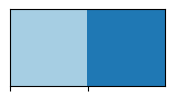

In [19]:
custom_palette1 = sns.color_palette('Paired',8)[0:2][:]
sns.palplot(custom_palette1)

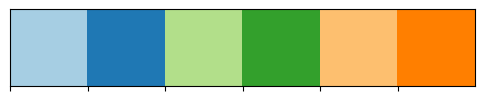

In [18]:
custom_palette2 = sns.color_palette('Paired',8)[0:4][:] + sns.color_palette('Paired',8)[6:8][:]
sns.palplot(custom_palette2)

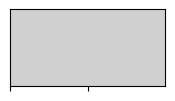

In [16]:
custom_palette3 = sns.color_palette(palette='Greys')[1], sns.color_palette(palette='Greys')[1]
sns.palplot(custom_palette3)

/home/ubuntu/.local/lib/python3.10/site-packages/statannot/statannot.py:555: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'star':
/home/ubuntu/.local/lib/python3.10/site-packages/statannot/statannot.py:557: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'simple':
/home/ubuntu/.local/lib/python3.10/site-packages/statannot/statannot.py:555: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'star':
/home/ubuntu/.local/lib/python3.10/site-packages/statannot/statannot.py:557: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'simple':


AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

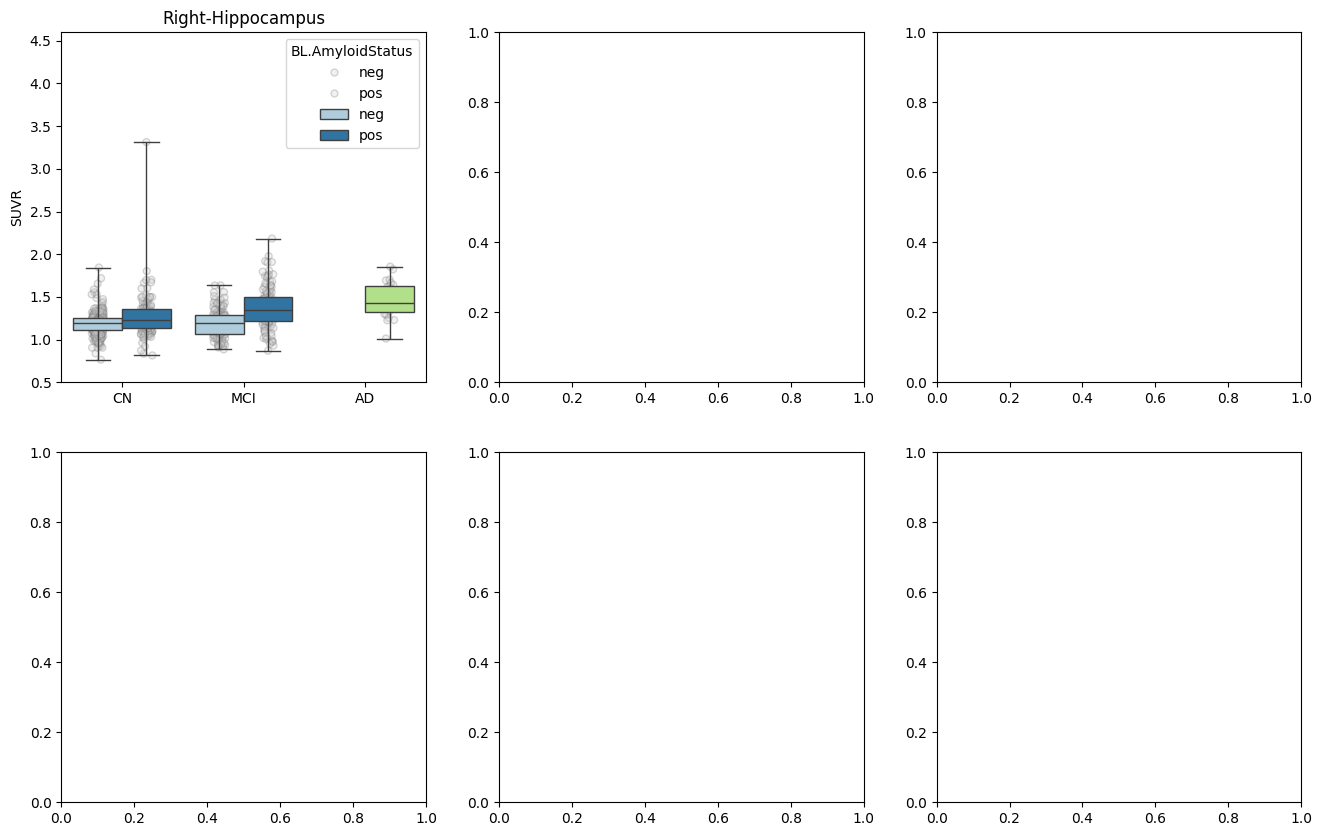

In [23]:

# Define the Braak areas dictionary
Braak_areas = {
    'Braak_1': ['ctx-lh-entorhinal', 'ctx-rh-entorhinal'],
    'Braak_2': ['Right-Hippocampus', 'Left-Hippocampus'],
    'Braak_3': ['ctx-lh-parahippocampal', 'ctx-rh-parahippocampal', 'ctx-lh-fusiform', 'ctx-rh-fusiform', 'ctx-lh-lingual', 'ctx-rh-lingual', 'Left-Amygdala', 'Right-Amygdala'],
    'Braak_4': ['ctx-lh-middletemporal', 'ctx-rh-middletemporal', 'Left-Thalamus', 'Right-Thalamus', 'ctx-lh-caudalanteriorcingulate', 'ctx-rh-caudalanteriorcingulate', 'ctx-lh-rostralanteriorcingulate', 'ctx-rh-rostralanteriorcingulate', 'ctx-lh-posteriorcingulate', 'ctx-rh-posteriorcingulate', 'ctx-lh-isthmuscingulate', 'ctx-rh-isthmuscingulate', 'ctx-lh-insula', 'ctx-rh-insula', 'ctx-lh-inferiortemporal', 'ctx-rh-inferiortemporal', 'ctx-lh-temporalpole', 'ctx-rh-temporalpole'],
    'Braak_5': ['ctx-lh-superiorfrontal', 'ctx-rh-superiorfrontal', 'ctx-lh-lateralorbitofrontal', 'ctx-rh-lateralorbitofrontal', 'ctx-lh-medialorbitofrontal', 'ctx-rh-medialorbitofrontal', 'ctx-lh-frontalpole', 'ctx-rh-frontalpole', 'ctx-lh-caudalmiddlefrontal', 'ctx-rh-caudalmiddlefrontal', 'ctx-lh-rostralmiddlefrontal', 'ctx-rh-rostralmiddlefrontal', 'ctx-lh-parsopercularis', 'ctx-rh-parsopercularis', 'ctx-lh-parsorbitalis', 'ctx-rh-parsorbitalis', 'ctx-lh-parstriangularis', 'ctx-rh-parstriangularis', 'Left-Caudate', 'Right-Caudate', 'Left-Putamen', 'Right-Putamen', 'ctx-lh-lateraloccipital', 'ctx-rh-lateraloccipital', 'ctx-lh-supramarginal', 'ctx-rh-supramarginal', 'ctx-lh-inferiorparietal', 'ctx-rh-inferiorparietal', 'ctx-lh-superiortemporal', 'ctx-rh-superiortemporal', 'Left-Pallidum', 'Right-Pallidum', 'ctx-lh-superiorparietal', 'ctx-rh-superiorparietal', 'ctx-lh-precuneus', 'ctx-rh-precuneus', 'ctx-lh-bankssts', 'ctx-rh-bankssts', 'Left-Accumbens-area', 'Right-Accumbens-area', 'ctx-lh-transversetemporal', 'ctx-rh-transversetemporal'],
    'Braak_6': ['ctx-lh-pericalcarine', 'ctx-rh-pericalcarine', 'ctx-lh-postcentral', 'ctx-rh-postcentral', 'ctx-lh-cuneus', 'ctx-rh-cuneus', 'ctx-lh-precentral', 'ctx-rh-precentral', 'ctx-lh-paracentral', 'ctx-rh-paracentral']
}

# Flatten the Braak areas into a list
Braak_areas_list = list(itertools.chain.from_iterable(Braak_areas.values()))

# Generate pairwise for t-test
pairwiseMatrix = [(("CN", "pos"), ("CN", "neg")), 
                  (("MCI", "pos"), ("MCI", "neg")),
                  (("MCI", "pos"), ("CN", "pos")),
                  (("AD", "pos"), ("CN", "pos")),
                  (("AD", "pos"), ("MCI", "pos"))]

fig, axs = plt.subplots(figsize=(16, 10), nrows=2, ncols=3)
n1axs = 0
n2axs = 0

# Plot region plots for each region in Braak_areas_list
for roi_name in Braak_areas_list:
    if roi_name not in group_roi_suvr.columns:
        continue  # Skip regions not found in the DataFrame

    # Remove 'NZ_Mean_' from region_column
    plot_title = roi_name.replace('wmean', '').replace('_', ' ROI ', 1).replace('_', '', 1)
    
    # Extract the SUVR
    roi_suvr = group_roi_suvr[['sid', roi_name]]
    
    # Add the best cost and diagnosis
    roi_suvr = pd.merge(roi_suvr, diag_file, on='sid')
    
    # Cohorts SUVR
    renamed_roi_suvr = roi_suvr[[roi_name, 'diag', 'BL.AmyloidStatus']] \
                                 .set_index('diag') \
                                 .reset_index() \
                                 .rename(columns={roi_name: 'SUVR'})
    
    # Change SUVR to float
    renamed_roi_suvr['SUVR'] = renamed_roi_suvr['SUVR'].astype(float)
    
    # Add points to show each observation
    sns.stripplot(data=renamed_roi_suvr, 
                  x='diag',
                  y='SUVR', 
                  dodge=True,
                  zorder=0,
                  hue='BL.AmyloidStatus',
                  palette=custom_palette3,
                  marker="o", linewidth=1, alpha=.3,
                  ax=axs[n1axs, n2axs])
    
    # Plot the orbital period with horizontal boxes
    sns.boxplot(data=renamed_roi_suvr, 
                x='diag', 
                y='SUVR', 
                hue='BL.AmyloidStatus',
                whis=[0, 100],
                width=.8,
                palette=custom_palette1,
                ax=axs[n1axs, n2axs])
    
    # Change the appearance of specific boxes
    if len(axs[n1axs, n2axs].patches) > 6:  # Ensure we have enough boxes to change
        mybox = axs[n1axs, n2axs].patches[4]
        mybox.set_facecolor(custom_palette2[2])
        mybox = axs[n1axs, n2axs].patches[5]
        mybox.set_facecolor(custom_palette2[3])
        mybox = axs[n1axs, n2axs].patches[6]
        mybox.set_facecolor(custom_palette2[5])
    
    # Tweak the visual presentation
    axs[n1axs, n2axs].set(ylabel="SUVR")
    axs[n1axs, n2axs].set(xlabel="")
    axs[n1axs, n2axs].set(title=plot_title)
    axs[n1axs, n2axs].set_ylim([0.5, 4.6])
    
    # Plotting the t-test comparison pairwise
    add_stat_annotation(axs[n1axs, n2axs],
                       data=renamed_roi_suvr,
                       x='diag',
                       y='SUVR',  
                       hue='BL.AmyloidStatus',          
                       box_pairs=pairwiseMatrix,
                       test='t-test_ind',
                       line_offset_to_box=0.03,
                       line_offset=0.01, 
                       comparisons_correction='bonferroni', 
                       text_format='star',
                       verbose=0)
    
    axs[n1axs, n2axs].set(ylabel='standardized uptake value ratio')
    axs[n1axs, n2axs].get_legend().set_visible(False)
    axs[n1axs, n2axs].set_xticks(np.arange(3), ['  CN-    CN+', '  MCI-   MCI+', '       AD+']) 

    if n2axs == 2:
        n1axs += 1
        n2axs = 0
    else:    
        n2axs += 1

fig.suptitle('Comparison of the standard uptake value ratio (SUVR)' + \
             ' in different cohorts:\n generated by TauQuant pipeline ' +\
             'from Tau-PET images', y=0.96, fontsize=16, ha='center')        
plt.savefig('/mnt/results/SUVR_tauquant.pdf', dpi=1200)
plt.show()

# Output the grouped data count
print(renamed_roi_suvr.groupby('diag').count().rename(columns={'SUVR': '#N'}))